# 快速入门：手写数字识别

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.7/tutorials/zh_cn/beginner/mindspore_quick_start.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.7/tutorials/zh_cn/beginner/mindspore_quick_start.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.7/tutorials/source_zh_cn/beginner/quick_start.ipynb)

本章节贯穿MindSpore深度学习的基本流程，以LeNet5网络模型为例子，实现深度学习中的常见任务。

## 下载并处理数据集

数据集对于模型训练非常重要，好的数据集可以有效提高训练精度和效率。示例中用到的MNIST数据集是由10类28∗28的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。

![mnist](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/tutorials/source_zh_cn/beginner/images/mnist.png)

> 你可以从[MNIST数据集下载页面](http://yann.lecun.com/exdb/mnist/)下载，解压后按下方目录结构放置。

MindSpore Vision套件提供了用于下载并处理MNIST数据集的Mnist模块，以下示例代码将数据集下载、解压到指定位置并进行数据处理：

In [1]:
from mindvision.dataset import Mnist

# 下载并处理MNIST数据集
download_train = Mnist(path="./mnist", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=True)

download_eval = Mnist(path="./mnist", split="test", batch_size=32, resize=32, download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()

参数说明：

- path：数据集路径。
- split：数据集类型，支持train、 test、infer，默认为train。
- batch_size：每个训练批次设定的数据大小，默认为32。
- repeat_num：训练时遍历数据集的次数，默认为1。
- shuffle：是否需要将数据集随机打乱（可选参数）。
- resize：输出图像的图像大小，默认为32*32。
- download：是否需要下载数据集，默认为False。

下载的数据集文件的目录结构如下：

```text
./mnist/
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

## 创建模型

按照LeNet的网络结构，LeNet除去输入层共有7层，其中有3个卷积层，2个子采样层，3个全连接层。

![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/tutorials/source_zh_cn/beginner/images/lenet.png)

MindSpore Vision套件提供了LeNet网络模型接口`lenet`， 定义网络模型如下：

In [2]:
from mindvision.classification.models import lenet

network = lenet(num_classes=10, pretrained=False)

## 定义损失函数和优化器

要训练神经网络模型，需要定义损失函数和优化器函数。

- 损失函数这里使用交叉熵损失函数`SoftmaxCrossEntropyWithLogits`。
- 优化器这里使用`Momentum`。

In [3]:
import mindspore.nn as nn
from mindspore.train import Model

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

## 训练及保存模型

在开始训练之前，MindSpore需要提前声明网络模型在训练过程中是否需要保存中间过程和结果，因此使用`ModelCheckpoint`接口用于保存网络模型和参数，以便进行后续的Fine-tuning（微调）操作。

In [4]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 设置模型保存参数
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="lenet", directory="./lenet", config=config_ck)

通过MindSpore提供的`model.train`接口可以方便地进行网络的训练，`LossMonitor`可以监控训练过程中`loss`值的变化。

In [5]:
from mindvision.engine.callback import LossMonitor

# 初始化模型参数
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})

# 训练网络模型
model.train(10, dataset_train, callbacks=[ckpoint, LossMonitor(0.01, 1875)])

Epoch:[  0/ 10], step:[ 1875/ 1875], loss:[0.314/0.314], time:2237.313 ms, lr:0.01000
Epoch time: 3577.754 ms, per step time: 1.908 ms, avg loss: 0.314
Epoch:[  1/ 10], step:[ 1875/ 1875], loss:[0.031/0.031], time:1306.982 ms, lr:0.01000
Epoch time: 1307.792 ms, per step time: 0.697 ms, avg loss: 0.031
Epoch:[  2/ 10], step:[ 1875/ 1875], loss:[0.007/0.007], time:1324.625 ms, lr:0.01000
Epoch time: 1325.340 ms, per step time: 0.707 ms, avg loss: 0.007
Epoch:[  3/ 10], step:[ 1875/ 1875], loss:[0.021/0.021], time:1396.733 ms, lr:0.01000
Epoch time: 1397.495 ms, per step time: 0.745 ms, avg loss: 0.021
Epoch:[  4/ 10], step:[ 1875/ 1875], loss:[0.028/0.028], time:1594.762 ms, lr:0.01000
Epoch time: 1595.549 ms, per step time: 0.851 ms, avg loss: 0.028
Epoch:[  5/ 10], step:[ 1875/ 1875], loss:[0.007/0.007], time:1242.175 ms, lr:0.01000
Epoch time: 1242.928 ms, per step time: 0.663 ms, avg loss: 0.007
Epoch:[  6/ 10], step:[ 1875/ 1875], loss:[0.033/0.033], time:1199.938 ms, lr:0.01000
Ep

训练过程中会打印loss值，loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。每个人运行的loss值有一定随机性，不一定完全相同。

通过模型运行测试数据集得到的结果，验证模型的泛化能力：

1. 使用`model.eval`接口读入测试数据集。
2. 使用保存后的模型参数进行推理。

In [6]:
acc = model.eval(dataset_eval)

print("{}".format(acc))

{'accuracy': 0.9903846153846154}


可以在打印信息中看出模型精度数据，示例中精度数据达到95%以上，模型质量良好。随着网络迭代次数增加，模型精度会进一步提高。

## 加载模型

In [7]:
from mindspore import load_checkpoint, load_param_into_net

# 加载已经保存的用于测试的模型
param_dict = load_checkpoint("./lenet/lenet-1_1875.ckpt")
# 加载参数到网络中
load_param_into_net(network, param_dict)

[]

> 阅读更多有关[加载模型](https://www.mindspore.cn/tutorials/zh-CN/r1.7/beginner/save_load.html#加载模型)的信息。

## 验证模型

我们使用生成的模型进行单个图片数据的分类预测，具体步骤如下：

> 被预测的图片会随机生成，每次运行结果可能会不一样。

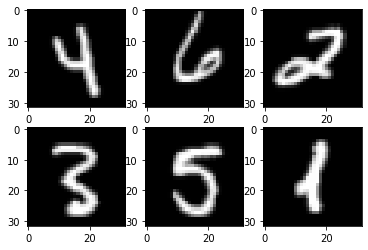

Predicted: "[4 6 2 3 5 1]", Actual: "[4 6 2 3 5 1]"


In [9]:
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

mnist = Mnist("./mnist", split="train", batch_size=6, resize=32)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')

从上面的打印结果可以看出，预测值与目标值完全一致。